# Example
#### Model: CNN
#### Data: MNIST (0,7) classes
#### 40% of label==0 are switched 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import pytorch_lightning as pl

class BinaryMNISTClassifier(pl.LightningModule):
    def __init__(self, input_size=28*28, hidden_sizes=[128,32], output_size=1, learning_rate=1e-3, dropout_rate=0.7):
        super(BinaryMNISTClassifier, self).__init__()
        self.learning_rate = learning_rate
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()
        )
        self.loss_fn = nn.BCELoss()
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)  # Adjust shape for BCELoss
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)
        logits = self(x)
        loss = self.loss_fn(logits, y)
        
        # Calculate accuracy
        preds = (logits > 0.5).float()
        accuracy = (preds == y).float().mean()
        
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_accuracy", accuracy, on_step=False, on_epoch=True)
        return {"test_loss": loss, "test_accuracy": accuracy}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [3]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.optim as optim
from torchmetrics.classification import Accuracy

class CNNBinaryMNISTClassifier(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, dropout_rate=0.5):
        super(CNNBinaryMNISTClassifier, self).__init__()
        self.learning_rate = learning_rate
        
        # Define the CNN architecture using nn.Sequential
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),  # (28, 28) -> (28, 28)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (28, 28) -> (28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (28, 28) -> (14, 14)
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),  # (14, 14) -> (14, 14)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # (14, 14) -> (14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (14, 14) -> (7, 7)
            
            nn.Flatten(),  # Flatten the output for the fully connected layers
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),  # Single output for binary classification
            nn.Sigmoid()  # Apply sigmoid to get output between 0 and 1
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)  # Adjust shape for BCELoss
        logits = self(x)
        loss = nn.BCELoss()(logits, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.float().unsqueeze(1)  # Adjust shape for BCELoss
        logits = self(x)
        loss = nn.BCELoss()(logits, y)
        
        # Calculate accuracy
        preds = (logits > 0.5).float()  # Threshold logits at 0.5 to make binary predictions
        accuracy = (preds == y).float().mean()

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_accuracy", accuracy, on_step=False, on_epoch=True)
        return {"test_loss": loss, "test_accuracy": accuracy}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [4]:
def create_binary_subset(dataset, label1, label2):
    # Filter for the two specified labels
    idx = (dataset.targets == label1) | (dataset.targets == label2)
    binary_subset = Subset(dataset, torch.where(idx)[0])
    
    # Map label1 to 0 and label2 to 1
    mapped_targets = torch.tensor([0 if label == label1 else 1 for label in dataset.targets[idx]])
    
    # Update dataset targets to reflect the binary mapping
    for i, original_idx in enumerate(torch.where(idx)[0]):
        binary_subset.dataset.targets[original_idx] = mapped_targets[i]
    
    return binary_subset



In [5]:
import torch
import random
import numpy as np
random.seed(42)

label1, label2 = 0, 7  # Choose any two labels here
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root="../data/", train=True, transform=transform, download=True)

binary_mnist_train = create_binary_subset(mnist_train, label1, label2)

# Step 1: Retrieve data and labels
data = []
labels = []
for img, label in binary_mnist_train:
    data.append(img)
    labels.append(label)

# Convert data and labels to tensors
data = torch.stack(data)  # shape: [num_samples, channels, height, width]
labels = torch.tensor(labels, dtype=torch.long)

# Step 2: Generate fake labels by switching 5% of them
fake_labels = labels.clone()  # Copy true labels
num_samples = len(labels)
num_switch = int(0.4 * np.where(labels==0)[0].shape[0])  # 20% of labels to switch
# indices_to_switch = random.sample(range(num_samples), num_switch)
indices_to_switch = random.sample(np.where(labels==0)[0].tolist(), num_switch)

# for idx in indices_to_switch:
#     fake_labels[idx] = label2 if fake_labels[idx] == label1 else label1
for idx in indices_to_switch:
    fake_labels[idx] = (fake_labels[idx] +1)%2
    
# Convert data and fake labels to tensors
data = data.float()  # Convert data to float32 tensor if needed
fake_labels = fake_labels.long()  # Convert fake_labels to long tensor


In [6]:
from tml.pipeline import Pipeline, ModelHandler
from tml.analysis import BinaryClassificationAnalysis


In [7]:

model_instance = BinaryMNISTClassifier(dropout_rate=0.3, learning_rate=1.0e-4)
# model_instance = CNNBinaryMNISTClassifier(dropout_rate=0.3, learning_rate=1.0e-4)

In [8]:
# Initialize the pipeline
model_handler = ModelHandler(model_instance=model_instance)
pipeline = Pipeline(model_handler, data=data, hard_targets=fake_labels, max_epochs=40, drop_iterations=100)

In [ ]:
pipeline.run(n_steps=25)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 104 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.419     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Seed: 42
Level 1 init: subset 43
Level 1 training: subset 43
Epoch 39: 100%|██████████| 122/122 [00:00<00:00, 224.04it/s, v_num=33, train_loss=0.336]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 122/122 [00:00<00:00, 223.14it/s, v_num=33, train_loss=0.336]
Level 1 predict: subset 43
Pruning: subset 43


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 104 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.419     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Level 2 init: subset 43
Level 2 training: subset 43
Epoch 37:  89%|████████▊ | 108/122 [00:00<00:00, 225.07it/s, v_num=33, train_loss=0.0155]

In [10]:
torch.unique(fake_labels)

tensor([0, 1])

In [11]:
(labels == fake_labels).sum()

tensor(9819)

In [13]:
np.where(labels==0)[0].shape[0]

5923

In [14]:
len(labels)

12188

ROC AUC: 0.8642363659686336, Brier Score: 0.18719524886011643


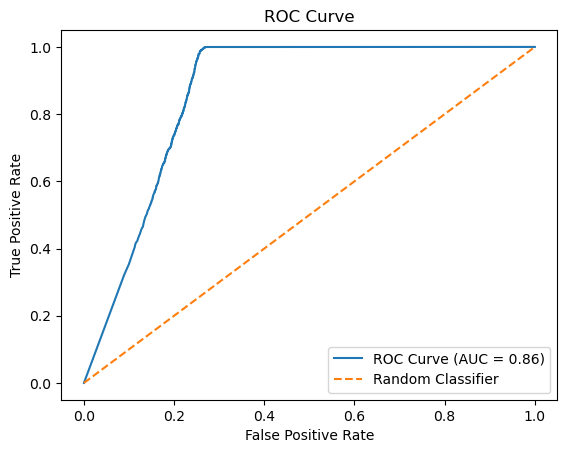

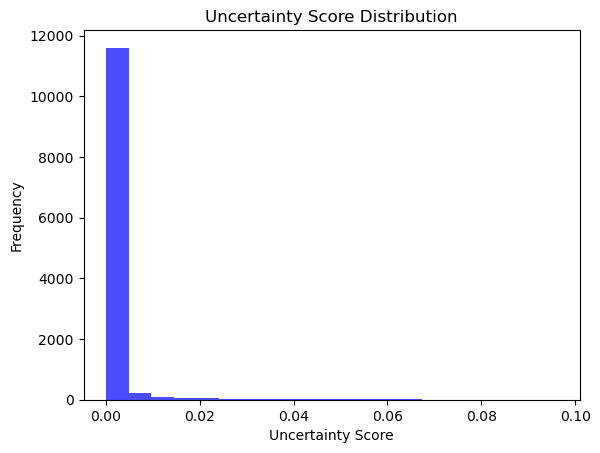

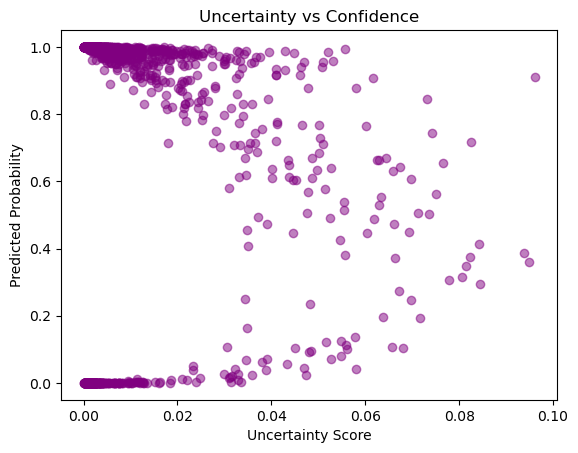

In [15]:
# Assuming labels, probability_scores, and uncertainty_scores are available
analysis = BinaryClassificationAnalysis(pipeline.hard_targets.cpu().numpy(),
                                        pipeline.probability_scores,
                                        pipeline.uncertainty_scores)

# Calculate metrics
roc_auc = analysis.calculate_roc_auc()
brier_score = analysis.calculate_brier_score()
print(f"ROC AUC: {roc_auc}, Brier Score: {brier_score}")

# Plotting
# analysis.plot_reliability_diagram()
analysis.plot_roc_curve()
analysis.plot_uncertainty_distribution()
analysis.plot_uncertainty_vs_confidence()


In [16]:
import pandas as pd

# Assuming the variables labels, fake_labels, probability_scores, and uncertainty_scores are already defined

# Convert each to a list or numpy array if they aren't already in those formats
labels = labels.cpu().numpy() if torch.is_tensor(labels) else labels
fake_labels = fake_labels.cpu().numpy() if torch.is_tensor(fake_labels) else fake_labels
probability_scores = pipeline.probability_scores
uncertainty_scores = pipeline.uncertainty_scores
confidence_adjusted_scores = (1 - probability_scores) * uncertainty_scores

# Ensure that all components have the same length
assert len(labels) == len(fake_labels) == len(probability_scores) == len(uncertainty_scores), "Mismatched lengths"

# Create the DataFrame
df = pd.DataFrame({
    'labels': labels,
    'fake_labels': fake_labels,
    'probability_scores': probability_scores,
    'uncertainty_scores': uncertainty_scores,
    'confidence_adjusted_scores': confidence_adjusted_scores,
    'label_issue': (labels+fake_labels)%2
})

# Display the DataFrame
df.head()


,labels,fake_labels,probability_scores,uncertainty_scores,confidence_adjusted_scores,label_issue
0,0,0,3.881275e-20,0.001283,1.283462e-03,0
1,1,1,9.999993e-01,0.000928,6.771972e-10,0
2,0,0,3.467434e-20,0.001359,1.359214e-03,0
3,1,1,9.932219e-01,0.005291,3.586023e-05,0
4,0,0,9.329674e-15,0.000771,7.711684e-04,0


In [17]:
df.sort_values('confidence_adjusted_scores')[-500:]['label_issue'].sum()

np.int64(134)

In [18]:
# Assuming your DataFrame is named df and has 'predicted_probability' and 'uncertainty_score' columns

# Set thresholds
uncertainty_threshold = 0.003 #1  # Adjust based on your data
high_confidence_threshold = 0.95
low_confidence_threshold = 0.05

# Identify noisy labels
df['high_uncert'] = (df['uncertainty_scores'] > uncertainty_threshold)
df['low_conf'] = ((df['probability_scores'] > low_confidence_threshold) & (df['probability_scores'] < high_confidence_threshold))

# Filter to see only noisy samples
# noisy_labels_df = df[df['is_noisy']]

# # Output or examine noisy labels
# print(noisy_labels_df)


In [19]:
df_conf = df[~df['low_conf']]

In [20]:
sum(df['labels'] != df['fake_labels'])

2369

In [21]:
df_conf

,labels,fake_labels,probability_scores,uncertainty_scores,confidence_adjusted_scores,label_issue,high_uncert,low_conf
0,0,0,3.881275e-20,0.001283,1.283462e-03,0,False,False
1,1,1,9.999993e-01,0.000928,6.771972e-10,0,False,False
2,0,0,3.467434e-20,0.001359,1.359214e-03,0,False,False
3,1,1,9.932219e-01,0.005291,3.586023e-05,0,True,False
4,0,0,9.329674e-15,0.000771,7.711684e-04,0,False,False
...,...,...,...,...,...,...,...,...
12183,1,1,9.999737e-01,0.000611,1.609615e-08,0,False,False
12184,0,0,3.250459e-17,0.000890,8.898287e-04,0,False,False
12185,1,1,9.993754e-01,0.004230,2.641658e-06,0,True,False
12186,0,0,2.018831e-22,0.001016,1.016193e-03,0,False,False


In [22]:
from tml.plotting import tml_plots
import os
import numpy as np

label_type = (labels == fake_labels)

### Ratio of true/noisy labels

In [23]:
df_cert = df[~df['high_uncert']]

In [24]:
df_cert_conf = df_cert[~df_cert['low_conf']]

In [25]:
print("Low Certainty and High Confidence Samples: ", sum(df_cert_conf['labels'] == df_cert_conf['fake_labels']) / df_cert_conf.shape[0])
print("Low Certainty Samples: ", sum(df_cert['labels'] == df_cert['fake_labels']) / df_cert.shape[0])
print("High Confidence Samples: ", sum(df_conf['labels'] == df_conf['fake_labels']) / df_conf.shape[0])
print("Overall Samples: ", sum(df['labels'] == df['fake_labels']) / df.shape[0])


Low Certainty and High Confidence Samples:  0.8210120143821801
Low Certainty Samples:  0.8210120143821801
High Confidence Samples:  0.8162550066755674
Overall Samples:  0.8056284870364293


In [26]:
df[df['high_uncert']]

,labels,fake_labels,probability_scores,uncertainty_scores,confidence_adjusted_scores,label_issue,high_uncert,low_conf
3,1,1,0.993222,0.005291,0.000036,0,True,False
6,1,1,0.987546,0.008702,0.000108,0,True,False
31,1,0,0.994842,0.007177,0.000037,1,True,False
33,1,1,0.974361,0.028868,0.000740,0,True,False
71,1,1,0.995110,0.010028,0.000049,0,True,False
...,...,...,...,...,...,...,...,...
12134,1,1,0.997505,0.003148,0.000008,0,True,False
12137,1,0,0.998657,0.004091,0.000005,1,True,False
12145,1,1,0.996701,0.003378,0.000011,0,True,False
12175,0,0,0.000395,0.006670,0.006667,0,True,False


In [27]:
(df[df['high_uncert']]['labels'] != df[df['high_uncert']]['fake_labels']).sum()

np.int64(328)

In [28]:
df[df['low_conf']]

,labels,fake_labels,probability_scores,uncertainty_scores,confidence_adjusted_scores,label_issue,high_uncert,low_conf
96,1,0,0.779214,0.021769,0.004806,1,True,True
192,1,0,0.819549,0.021466,0.003874,1,True,True
219,1,1,0.845602,0.073150,0.011294,0,True,True
221,1,0,0.712846,0.027673,0.007946,1,True,True
271,1,0,0.890015,0.005531,0.000608,1,True,True
...,...,...,...,...,...,...,...,...
11654,1,0,0.610306,0.048685,0.018972,1,True,True
11709,1,1,0.942686,0.027283,0.001564,0,True,True
11723,1,0,0.471780,0.066042,0.034885,1,True,True
11899,1,0,0.713312,0.035486,0.010173,1,True,True


In [29]:
(df[df['low_conf']]['labels'] != df[df['low_conf']]['fake_labels']).sum()

np.int64(167)

In [30]:
df['label_issue'].sum()

np.int64(2369)

In [31]:
data.shape

torch.Size([12188, 1, 28, 28])

## Train model on original data vs. on the pruned data

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

# Define a custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images  # Tensor with shape [N, 1, 28, 28]
        self.labels = torch.tensor(labels, dtype=torch.float32)  # Binary labels as a 1D tensor

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


def train_model(train_data, train_labels, test_data=None, test_labels=None, learning_rate=1e-4, dropout_rate=0.7, batch_size=128, max_epochs=40, model_type='cnn'):
    train_dataset = ImageDataset(train_data, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    if test_data != None:
        test_dataset = ImageDataset(test_data, test_labels)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    else:
        test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        
    if model_type == 'mlp':
        model = BinaryMNISTClassifier(learning_rate=learning_rate, dropout_rate=dropout_rate)
    elif model_type == 'cnn':
        model = CNNBinaryMNISTClassifier(learning_rate=learning_rate, dropout_rate=dropout_rate)
    
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        log_every_n_steps=10,
        enable_checkpointing=False, 
        accelerator="auto",
        devices="auto"
    )
    
    trainer.fit(model, train_loader)

    trainer.test(model, test_loader)

### Train and Prediction on the original data with no noise

In [34]:
model_type= 'mlp'
train_model(data, labels, test_data=data, test_labels=labels, model_type=model_type)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 104 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.419     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 96/96 [00:00<00:00, 202.81it/s, v_num=49, train_loss=0.0133]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 96/96 [00:00<00:00, 201.86it/s, v_num=49, train_loss=0.0133]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 96/96 [00:00<00:00, 298.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9985231161117554
        test_loss           0.00431372644379735
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Train and Prediction on the original data with noisy labels

In [35]:
train_model(data, fake_labels,  test_data=data, test_labels=labels, model_type=model_type)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 104 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.419     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 96/96 [00:00<00:00, 201.72it/s, v_num=50, train_loss=0.345]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 96/96 [00:00<00:00, 200.85it/s, v_num=50, train_loss=0.345]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 96/96 [00:00<00:00, 298.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9931900501251221
        test_loss           0.2704441249370575
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Train and Prediction on the cleaned data 
(based on confidence_adjusted_scores (1 - probability_scores) * uncertainty_scores and drop the top 500 samples )

In [36]:
# Get all indices from the DataFrame
all_indices = set(df.index)

# Indices to drop (from your code)
drop_ind = df.sort_values('confidence_adjusted_scores')[-500:]['label_issue'].index.tolist()

# Convert drop_ind to a set
drop_ind_set = set(drop_ind)

# Get the indices NOT to drop
retain_ind = list(all_indices - drop_ind_set)

clean_fake_labels = fake_labels[retain_ind]
clean_data = data[retain_ind]

In [37]:
train_model(clean_data, clean_fake_labels,  test_data=data, test_labels=labels, model_type=model_type)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 104 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.419     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 92/92 [00:00<00:00, 201.33it/s, v_num=51, train_loss=0.347]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 92/92 [00:00<00:00, 200.48it/s, v_num=51, train_loss=0.347]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 96/96 [00:00<00:00, 298.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9949950575828552
        test_loss           0.2690085470676422
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Train and Prediction on the cleaned data 
(based on thresholds on uncertainty scores and probability scores)

In [38]:
retain_ind = df[~df['high_uncert'] & ~df['low_conf']].index.tolist()

clean_fake_labels = fake_labels[retain_ind]
clean_data = data[retain_ind]

In [39]:
train_model(clean_data, clean_fake_labels,  test_data=data, test_labels=labels, model_type=model_type)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 104 K  | train
1 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.419     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 90/90 [00:00<00:00, 203.74it/s, v_num=52, train_loss=0.323]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 90/90 [00:00<00:00, 202.85it/s, v_num=52, train_loss=0.323]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 96/96 [00:00<00:00, 300.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9758779406547546
        test_loss           0.2957037091255188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
